<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/models/old%20models/full_size_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
from keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random
import torchvision.transforms.functional as F

from google.colab import userdata

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [3]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/StuartLiv/CPSC-440-Project
%pwd

fatal: destination path 'CPSC-440-Project' already exists and is not an empty directory.


'/content'

In [4]:
# !pip install pytorch-msssim -q
from pytorch_msssim import ms_ssim

# 2. Preprocess data

Datasets:
- `medset_multisize`
  - Single datasets. Dataset construction code in repo too
  - 12000 Images, in randomized order
  - Res 256x256 (grayscale images also available in 128x128, 64x64, 32x32)


In [6]:
# !pip install -q kornia
from kornia.color import rgb_to_lab, lab_to_rgb

In [4]:
''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path,cut=None,end=False):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  if cut is not None:
    files = files[:cut]
  if end:
    files = files[-1:]

  arr = []
  for i in tqdm(files):
    img = load_img(path + '/'+i)
    arr.append(img_to_array(img) / 255)

  return np.array(arr)


Load datasets, partition sets, and make tensors in color-layer order for convolutions



In [1]:
# training_proportion = 0.8
# validation_proportion = 0.0

# def load_and_partition(path):
#   arr = make_image_arr(path)
#   cutoff = int(len(arr)*training_proportion)
#   return arr[:cutoff], arr[cutoff:]

def make_rgb_tensor(arr):
  #Axis transformation: Shape (n, h, w, 3) -> (n, 3, h, w)
  #Inversion is np.moveaxis(arr, [2,2], [1,1])
  return torch.from_numpy(np.moveaxis(arr, [3,1], [1,2])).to(device)

def make_lab_tensor(arr):
  #Axis transformation: Shape (n, h, w, 3) -> (n, 3, h, w)
  #Inversion is np.moveaxis(arr, [2,2], [1,1])
  return rgb_to_lab(make_rgb_tensor(arr))

#Extract single channel, since all 3 are the same in gray images
def make_gray_tensor(arr):
  return make_rgb_tensor(arr)[:, 0:1, :, :]


In [19]:
rgb_np = make_image_arr('/content/CPSC-440-Project/datasets/medset_multisize/color',cut=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1153.61it/s]


In [22]:
import skimage

In [24]:
lab_np = skimage.color.rgb2lab(rgb_np)

In [25]:
color = make_lab_tensor(lab_np)

OutOfMemoryError: CUDA out of memory. Tried to allocate 750.00 MiB. GPU 0 has a total capacity of 22.17 GiB of which 726.88 MiB is free. Process 241533 has 21.45 GiB memory in use. Of the allocated memory 20.58 GiB is allocated by PyTorch, and 677.00 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [20]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
torch.cuda.empty_cache()

In [21]:
# crashes L4 session

color = make_lab_tensor(rgb_np)


OutOfMemoryError: CUDA out of memory. Tried to allocate 750.00 MiB. GPU 0 has a total capacity of 22.17 GiB of which 726.88 MiB is free. Process 241533 has 21.45 GiB memory in use. Of the allocated memory 20.58 GiB is allocated by PyTorch, and 677.00 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [8]:
gray_train, gray_test = load_and_partition('/content/CPSC-440-Project/datasets/medset_multisize/gray')


100%|██████████| 12000/12000 [00:16<00:00, 739.22it/s]


In [10]:

assert(len(color_train) == len(gray_train) and len(color_test) == len(gray_test))
n_train = len(color_train)
n_test = len(color_test)


In [ ]:
color_train_tensors = make_lab_tensor(color_train)
# color_test_tensors = make_lab_tensor(color_test)


In [ ]:

gray_train_tensors = make_gray_tensor(gray_train)
gray_test_tensors = make_gray_tensor(gray_test)

5005


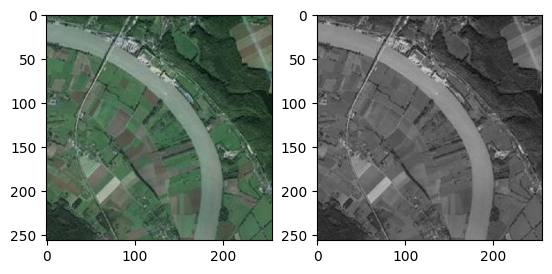

3597


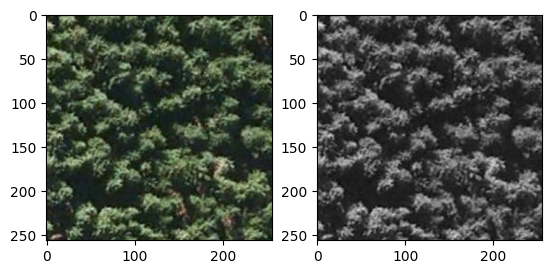

8043


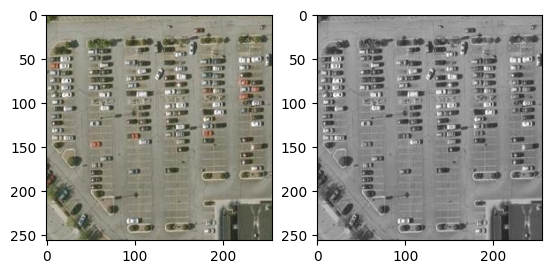

In [ ]:
for i in np.random.randint(n_train,size=3):
  print(i)
  plt.subplot(1,2,1)
  plt.imshow(F.to_pil_image(lab_to_rgb(color_train_tensors[i])))
  plt.subplot(1,2,2)
  plt.imshow(F.to_pil_image(lab_to_rgb(gray_train_tensors[i])))
  plt.show()

# 3. Model
Model generated below:

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 3, 3, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
autoencoder = Autoencoder()

Train Model (SGD)

In [ ]:
np.log(1)

0.0

In [ ]:
def ms_ssimloss(input, target):
  return -ms_ssim(input, target)
criterion = ms_ssimloss
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
autoencoder.train()
autoencoder.to(device)

# Training loop
num_epochs = 3
num_iterations = 1000
batch_size=32
for epoch in range(num_epochs):
  for iteration in tqdm(range(num_iterations)):
      running_loss = 0.0
      batch_indexes = torch.randint(high=n_train, size=(batch_size,1))

      inputs = gray_train_tensors[batch_indexes].squeeze(1).to(device)
      targets = color_train_tensors[batch_indexes].squeeze(1).to(device)

      outputs = autoencoder(inputs)
      loss = criterion(outputs, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
  print('[%d] loss: %.5f' % (epoch+1, running_loss / batch_size))

print('Finished Training')

100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]


[1] loss: -0.03125


100%|██████████| 1000/1000 [03:39<00:00,  4.55it/s]


[2] loss: -0.03125


100%|██████████| 1000/1000 [03:39<00:00,  4.55it/s]

[3] loss: -0.03125
Finished Training


Simple Image Space Exploration

i: 1653
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(0.0012, grad_fn=<MseLossBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 256, 256])) that is different to the input size (torch.Size([1, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


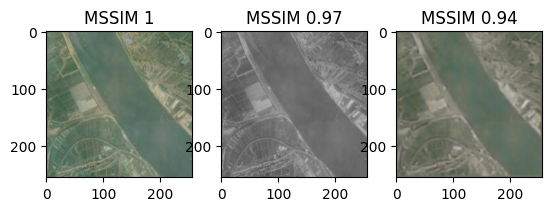

i: 545
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(0.0022, grad_fn=<MseLossBackward0>)


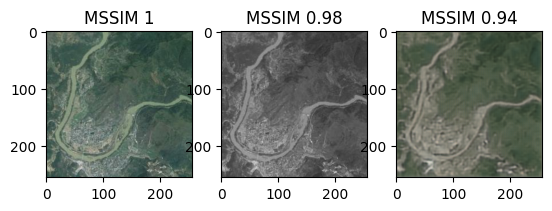

i: 477
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(0.0130, grad_fn=<MseLossBackward0>)


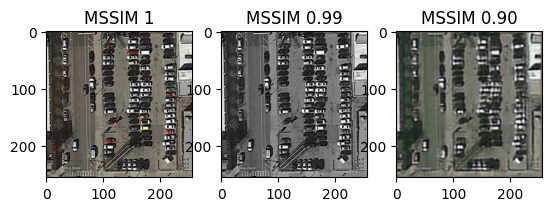

In [ ]:
autoencoder.eval()
for i in np.random.randint(n_test,size=3):
  image_bw = gray_test[i]
  image_c = color_test[i]

  # Colorize the image
  t = gray_test_tensors[i].unsqueeze(0).to(device)
  colorized_image = autoencoder(t)
  colorized_image_format = np.moveaxis(colorized_image.squeeze().cpu().detach().numpy(), [1,2], [0,1])

  print("i:", i)
  print("LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT")
  print(nn.MSELoss()(colorized_image.cpu(), color_test_tensors[i]))

  plt.subplot(1,3,1)
  plt.imshow(image_c)
  plt.title(f"MSSIM 1")

  plt.subplot(1,3,2)
  plt.imshow(image_bw)
  input_mssim = ms_ssim(color_test_tensors[i].unsqueeze(0).to(device), gray_test_tensors[i].repeat(3,1,1).unsqueeze(0).to(device), data_range=1, size_average=True) # return scalar
  plt.title(f"MSSIM {input_mssim:.2f}")

  plt.subplot(1,3,3)
  plt.imshow(colorized_image_format)
  output_mssim = ms_ssim(color_test_tensors[i].unsqueeze(0).to(device), colorized_image.to(device), data_range=1, size_average=True) # return scalar
  plt.title(f"MSSIM {output_mssim:.2f}")

  plt.show()

# LEFT TO RIGHT: ORIGINAL, GRAYSCALE, COLORIZED

In [ ]:
torch.save(autoencoder.decoder,'/content/CPSC-440-Project/models/ssimloss/decoder_weights_256_4epochnegssim')

In [ ]:
torch.save(autoencoder.encoder,'/content/CPSC-440-Project/models/ssimloss/full_size_encoder_weights_256_4epochnegssim')

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [ ]:
%cd CPSC-440-Project

/content/CPSC-440-Project


In [ ]:

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!git add .

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   models/ssimloss/decoder_weights_256_4epochnegssim
	new file:   models/ssimloss/full_size_encoder_weights_256_4epochnegssim



In [ ]:
!git commit -m "256x256 model weights with negative msssim loss, trained 4 epochs"

[main e82166f39] 256x256 model weights with negative msssim loss, trained 4 epochs
 2 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 models/ssimloss/decoder_weights_256_4epochnegssim
 create mode 100644 models/ssimloss/full_size_encoder_weights_256_4epochnegssim


In [ ]:
!git push --force

Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 16 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 2.81 MiB | 4.31 MiB/s, done.
Total 6 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/StuartLiv/CPSC-440-Project
   423455dcb..e82166f39  main -> main


# 4. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!